Primeros registros del dataset 'datasettokens.csv':


,Coin ID,Capitalización total de mercado (market cap),Categorías
0,0x0-ai-ai-smart-contract,254680974.0,"['Artificial Intelligence (AI)', 'Privacy Coin..."
1,0xdefcafe,0.0,"['Artificial Intelligence (AI)', 'Decentralize..."
2,1000troll,0.0,['Meme']
3,-2,17786.5,"['Meme', 'Ethereum Ecosystem']"
4,2dai-io,2110874.0,"['Telegram Apps', 'Artificial Intelligence (AI..."



Primeros registros del dataset 'exchange_cryptos.csv':


,Exchange,Crypto ID,Cantidad en el Exchange (USD)
0,Binance,batcat,3.172390e+09
1,Binance,bridged-binance-peg-ethereum-opbnb,2.954334e+09
2,Binance,beam-bridged-usdc-beam,1.157090e+09
3,Binance,bridged-wrapped-bitcoin-manta-pacific,2.091592e+07
4,Binance,solana,1.815564e+09


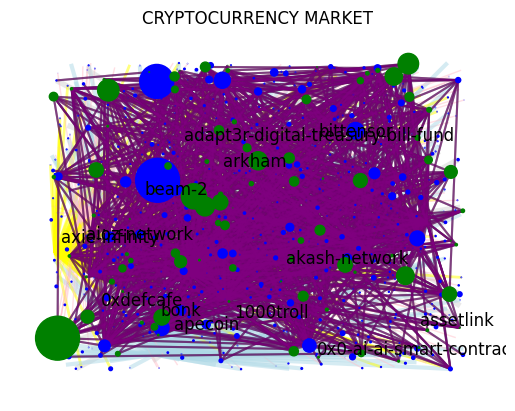

Se dibujaron 932 vértices de Coin ID y 95 vértices de Exchange.
Número de aristas de categoría 'Meme': 423
Número de aristas de categoría 'Artificial Intelligence (AI)': 135
Número de aristas de categoría 'Gaming (GameFi)': 288
Número de aristas de categoría 'Real World Assets (RWA)': 106
Se dibujaron 1938 aristas en total.


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

# Cargar datos desde los archivos CSV
dataset_tokens = pd.read_csv('datasettokens.csv')
exchange_cryptos = pd.read_csv('exchange_cryptos.csv')

# Visualizar los primeros registros de los datasets
print("Primeros registros del dataset 'datasettokens.csv':")
display(dataset_tokens.head())

print("\nPrimeros registros del dataset 'exchange_cryptos.csv':")
display(exchange_cryptos.head())

# Crear un grafo bipartito
B = nx.Graph()

# Agregar nodos de Coin ID y Exchange
B.add_nodes_from(dataset_tokens['Coin ID'], bipartite=0)
B.add_nodes_from(exchange_cryptos['Exchange'], bipartite=1)

# Crear un diccionario para almacenar la capitalización total de mercado por Coin ID
market_cap_dict = dict(zip(dataset_tokens['Coin ID'], dataset_tokens['Capitalización total de mercado (market cap)']))

# Crear un diccionario para almacenar la cantidad total en el Exchange por Exchange
exchange_total_dict = exchange_cryptos.groupby('Exchange')['Cantidad en el Exchange (USD)'].sum().to_dict()

# Dibujar nodos con diferentes tamaños
coin_id_sizes = [market_cap_dict.get(node, 0) for node in B.nodes if node in dataset_tokens['Coin ID'].values]
exchange_sizes = [exchange_total_dict.get(node, 0) for node in B.nodes if node in exchange_cryptos['Exchange'].values]

# Normalizar tamaños
coin_id_max_size = max(coin_id_sizes)
coin_id_sizes_normalized = [1000 * size / coin_id_max_size for size in coin_id_sizes]  # Escalar para una mejor visualización
exchange_max_size = max(exchange_sizes)
exchange_sizes_normalized = [1000 * size / exchange_max_size for size in exchange_sizes]  # Escalar para una mejor visualización

# Función para obtener las categorías de un nodo Coin ID
def get_categories(coin_id):
    categories_str = dataset_tokens.loc[dataset_tokens['Coin ID'] == coin_id, 'Categorías'].values[0]
    return ast.literal_eval(categories_str) if pd.notnull(categories_str) else []

# Crear un diccionario para mapear las categorías a colores y pesos
category_color_weight = {
    "Meme": ("pink", 1),
    "Artificial Intelligence (AI)": ("yellow", 2),
    "Gaming (GameFi)": ("lightblue", 3),
    "Real World Assets (RWA)": ("lightgrey", 4)
}

# Contadores para las aristas por categoría
category_edge_count = {category: 0 for category in category_color_weight}

# Agregar relaciones entre los vértices de Coin ID según las categorías
for coin_id in dataset_tokens['Coin ID']:
    categories = get_categories(coin_id)
    for category in categories:
        if category in category_color_weight:
            color, weight = category_color_weight[category]
            B.add_edge(coin_id, category, color=color, weight=weight)
            category_edge_count[category] += 1

# Conectar vértices Coin ID y Exchange mediante Crypto ID con peso
for index, row in exchange_cryptos.iterrows():
    exchange = row['Exchange']
    crypto_id = row['Crypto ID']
    weight = row['Cantidad en el Exchange (USD)']
    if crypto_id in dataset_tokens['Coin ID'].values:
        B.add_edge(exchange, crypto_id, weight=weight)

# Dibujar grafo
pos = nx.random_layout(B)  # Posiciones de los nodos
nx.draw_networkx_nodes(B, pos, nodelist=[node for node in B.nodes if node in dataset_tokens['Coin ID'].values],
                       node_size=coin_id_sizes_normalized, node_color='blue')
nx.draw_networkx_nodes(B, pos, nodelist=[node for node in B.nodes if node in exchange_cryptos['Exchange'].values],
                       node_size=exchange_sizes_normalized, node_color='green')

# Etiquetas de los 10 vértices de Coin ID con más volumen
coin_id_labels = {}
top_coin_id = sorted(coin_id_sizes, reverse=True)[:10]
for node, size in zip(B.nodes, coin_id_sizes):
    if size in top_coin_id:
        coin_id_labels[node] = node

nx.draw_networkx_labels(B, pos, labels=coin_id_labels, font_color='black')

# Etiquetas de los 3 exchanges con más volumen
top_exchange = sorted(exchange_sizes, reverse=True)[:3]
exchange_labels = {node: node for node, size in zip(B.nodes, exchange_sizes) if size in top_exchange}
nx.draw_networkx_labels(B, pos, labels=exchange_labels, font_color='black')

# Dibujar aristas de categorías
for u, v, data in B.edges(data=True):
    if v in category_color_weight:  # Si el nodo de destino es una categoría
        nx.draw_networkx_edges(B, pos, edgelist=[(u, v)], width=data['weight'], edge_color=data['color'], alpha=0.5)

# Dibujar aristas de intercambio
edge_list = [(u, v) for u, v in B.edges() if v not in category_color_weight]
nx.draw_networkx_edges(B, pos, edgelist=edge_list, width=1.5, alpha=0.5)

# Dibujar aristas de intercambio con color púrpura
exchange_edges = [(u, v) for u, v in B.edges() if v in exchange_cryptos['Exchange'].values and u in dataset_tokens['Coin ID'].values]
nx.draw_networkx_edges(B, pos, edgelist=exchange_edges, width=1.5, edge_color='purple', alpha=0.5)

plt.title("CRYPTOCURRENCY MARKET")
plt.axis('off')
plt.show()

# Contar el número de nodos de Coin ID y Exchange
num_coin_id = len([node for node, attr in B.nodes(data=True) if 'bipartite' in attr and attr['bipartite'] == 0])
num_exchange = len(B) - num_coin_id

# Mostrar el número de nodos de Coin ID y Exchange
print(f"Se dibujaron {num_coin_id} vértices de Coin ID y {num_exchange} vértices de Exchange.")

# Mostrar el número de aristas por categoría
for category, count in category_edge_count.items():
    print(f"Número de aristas de categoría '{category}': {count}")

# Contar el número total de aristas
num_edges = B.number_of_edges()
print(f"Se dibujaron {num_edges} aristas en total.")


